In [1]:
import sys
sys.path = ['D:\personal\Cristian\GitHub\HAI-BM\holisticai']  + sys.path

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from holisticai.datasets import load_adult
def load_preprocessed_adult():
    dataset = load_adult()
    df = pd.concat([dataset["data"], dataset["target"]], axis=1)
    protected_variables = ["sex", "race"]
    output_variable = ["class"]
    favorable_label = 1
    unfavorable_label = 0

    y = df[output_variable].replace(
        {">50K": favorable_label, "<=50K": unfavorable_label}
    )
    x = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1))

    group = ["sex"]
    group_a = df[group] == "Female"
    group_b = df[group] == "Male"
    data = [x, y, group_a, group_b]

    dataset = train_test_split(*data, test_size=0.5, shuffle=True)
    train_data = dataset[::2]
    test_data = dataset[1::2]
    return train_data, test_data

In [3]:

from data_utils import BDataset
import numpy as np
from holisticai.utils.transformers.bias import SensitiveGroups
from holisticai.bias.metrics import multiclass_bias_metrics
from tests.testing_utils._tests_data_utils import load_preprocessed_us_crime

device='cpu'
hidden_size = 80
lambd = 0.7
nb_classes = 5
train_data, test_data = load_preprocessed_us_crime(nb_classes=nb_classes)
#train_data, test_data = load_preprocessed_adult()
train_data = [np.array(d) for d in train_data]
from sklearn.preprocessing import StandardScaler
train_data[0] =  StandardScaler().fit_transform(train_data[0])
train_data[1] =  train_data[1].flatten()
sens_groups = SensitiveGroups()

x, y, group_a, group_b = train_data

input_size = x.shape[1]

sensitive_features = np.c_[group_a, group_b]
groups_num = np.array(
    sens_groups.fit_transform(sensitive_features, convert_numeric=True)
)

ratio = groups_num.sum() / len(groups_num)
dataset = BDataset(x, y, groups_num, device=device)

c:\Users\Cristian\anaconda3\envs\metrics\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def evaluate_classifier(y, y_pred, group_a,group_b):
    from holisticai.bias.metrics import multiclass_bias_metrics
    from sklearn.metrics import accuracy_score
    import numpy as np
    acc = accuracy_score(y,y_pred)
    group_num = sens_groups.transform(np.c_[group_a,group_b], convert_numeric=True)
    df_baseline = multiclass_bias_metrics(group_num, y_pred, y, metric_type='both')
    print(acc)
    print(df_baseline)

In [5]:
import random
import torch
import torch.nn as nn
from torch_utils import FeaturizerPhi

class ClassifierModel(nn.Module):
    def __init__(self, input_size, hidden_size, truncated=False, nb_classes=None):
        # Define the featurizer layers.
        super().__init__()
        self.truncated = truncated
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.SELU())
        
        if not self.truncated:
            self.output_layer = nn.Linear(hidden_size, nb_classes)
            
    def forward(self, X):
        X = self.layers(X)
        if not self.truncated:
            return self.output_layer(X)
        return X

In [6]:
from trainer import Trainer,TrainArgs
from algorithm_utils import Estimator

classifier = ClassifierModel(input_size, hidden_size=hidden_size, nb_classes=nb_classes)

train_args = TrainArgs(epochs=20)
trainer = Trainer(train_args=train_args, model=classifier, dataset=dataset)
trainer.train()

estimator_baseline = Estimator(classifier)

100%|██████████| 20/20 [00:02<00:00,  9.43it/s]


In [7]:
y_pred = estimator_baseline.predict(x)
evaluate_classifier(y, y_pred, group_a, group_b)

0.8594730238393977
                                             Value  Reference
Metric                                                       
Max Multiclass Statistical Parity         0.539401          0
Mean Multiclass Statistical Parity        0.539401          0
Max Multiclass Equality of Opportunity    0.352973          0
Max Multiclass Average Odds               0.352973          0
Max Multiclass True Positive Difference   0.352973          0
Mean Multiclass Equality of Opportunity   0.352973          0
Mean Multiclass Average Odds              0.352973          0
Mean Multiclass True Positive Difference  0.352973          0


In [8]:
from torch_utils import TwoLayerNN
from trainer import TrainerFSCS,TrainArgs


classifier = ClassifierModel(input_size, hidden_size=hidden_size, truncated=True)
fscs_model = TwoLayerNN(hidden_size=hidden_size, phi=classifier, nb_classes=nb_classes, ratio=1-ratio)

train_args = TrainArgs(epochs=20)
trainer = TrainerFSCS(train_args=train_args, model=fscs_model, dataset=dataset, lambd=lambd)
trainer.train()

100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


In [9]:
from algorithm_utils import Estimator
def predictor(x , d):
    return fscs_model(x,d)[0]

estimator = Estimator(predictor= predictor)

In [10]:
group_num = sens_groups.transform(np.c_[group_a,group_b], convert_numeric=True)
y_pred = estimator.predict(x, group_num)
evaluate_classifier(y, y_pred, group_a, group_b)

0.8350062735257214
                                             Value  Reference
Metric                                                       
Max Multiclass Statistical Parity         0.503945          0
Mean Multiclass Statistical Parity        0.503945          0
Max Multiclass Equality of Opportunity    0.357258          0
Max Multiclass Average Odds               0.357258          0
Max Multiclass True Positive Difference   0.357258          0
Mean Multiclass Equality of Opportunity   0.357258          0
Mean Multiclass Average Odds              0.357258          0
Mean Multiclass True Positive Difference  0.357258          0


In [11]:
from algorithm_utils import explore_coverage

y_proba_baseline = estimator_baseline.predict_proba(x)
y_proba = estimator.predict_proba(x, group_num)

res_baseline = explore_coverage(y_proba_baseline, y, group_num)
res = explore_coverage(y_proba, y, group_num)

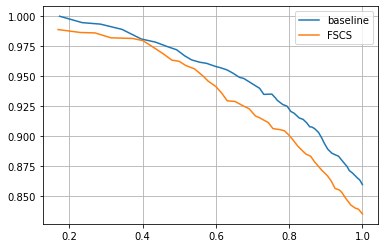

In [12]:
import matplotlib.pyplot as plt
plt.plot(res_baseline[1],res_baseline[0])
plt.plot(res[1],res[0])
plt.legend(['baseline', 'FSCS'])
plt.grid()